# SKNY_paper_Sakai_et_al

In [1]:
# import library
import skny as sk
import stlearn as st
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import anndata as ad
import cv2
import seaborn as sns
import statsmodels.api as sm
import os

/Users/sakai/miniconda3/envs/skny/lib/python3.8/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


In [2]:
# !mkdir tutorial_data
# !mkdir tutorial_data/xenium_data
# !wget -P tutorial_data/xenium_data/ https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5
# !wget -P tutorial_data/xenium_data/ https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz

## Figure 2.  Detection of spatial domain with Xenium data accurately discriminates between the tumor and stromal region.

In [3]:
# plot for each ROI
adata = st.ReadXenium(
    feature_cell_matrix_file="tutorial_data/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5",
    cell_summary_file="tutorial_data/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz",
    library_id="Xenium_FFPE_Human_Breast_Cancer_Rep1",
    image_path="tutorial_data/xenium_data/CS1384_post-CS0_H&E_S1A_RGB-shlee-crop.png",
    scale=1,
    spot_diameter_fullres=10 # Recommend
)

Added tissue image to the object!


In [4]:
# Gridding at 10μm interval using stlearn
N_COL = int((adata.obs.imagecol.max() - adata.obs.imagecol.min()) / 10)
N_ROW = int((adata.obs.imagerow.max() - adata.obs.imagerow.min()) / 10)
grid = st.tl.cci.grid(adata, n_row=N_ROW, n_col=N_COL, n_cpus=48, verbose=False)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
# contour tumor and calculate distance
grid = sk.pp.calculate_distance(
    grid, pos_marker_ls=['CDH1'], 
)

### Figure 2B

(-0.5, 751.5, 546.5, -0.5)

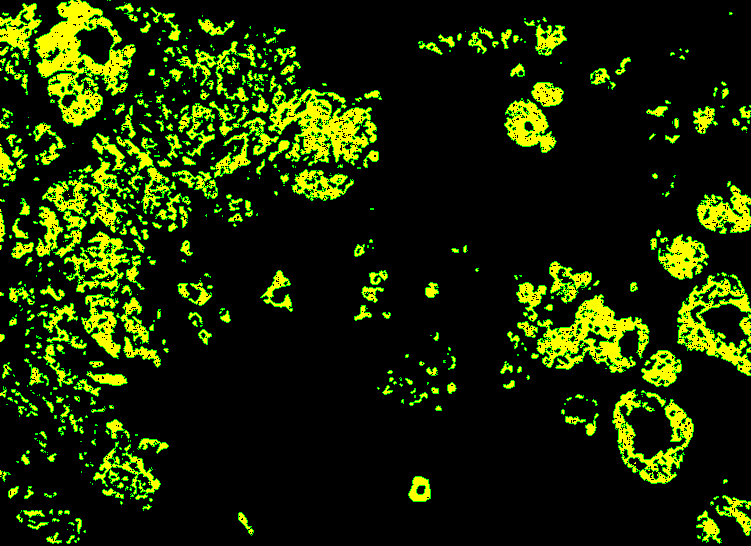

In [6]:
# Figure 2B
# save figure
fig, ax = plt.subplots(figsize=(N_COL, N_ROW), dpi=1, tight_layout=True)

ax.imshow(
    cv2.cvtColor(grid.uns["marker_median_delineation"], cv2.COLOR_BGR2RGB)
)
ax.axis('off')
#plt.savefig("Figure_2B.png", dpi=1)

### Figure 2C

(-0.5, 751.5, 546.5, -0.5)

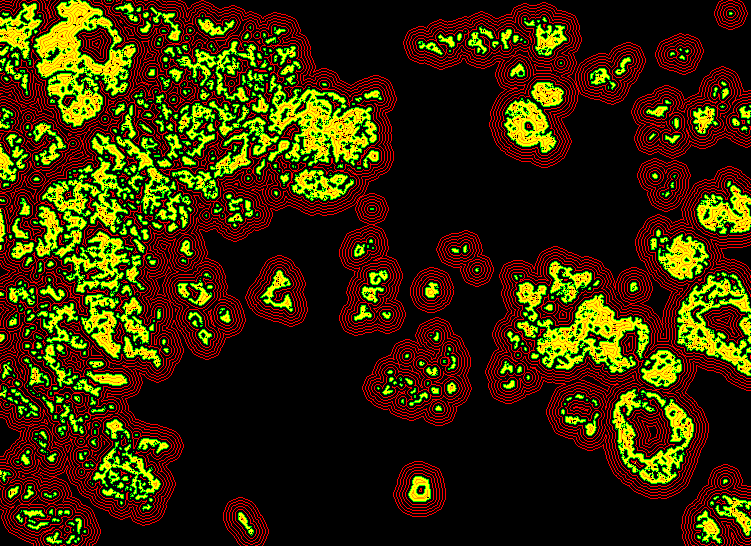

In [7]:
# Figure 2C
# save figure
fig, ax = plt.subplots(figsize=(N_COL, N_ROW), dpi=1, tight_layout=True)

ax.imshow(
    cv2.cvtColor(grid.uns["shotest_30_delineation"], cv2.COLOR_BGR2RGB)
)
ax.axis('off')
#plt.savefig("Figure_2C.png", dpi=1)

### Figure 2D

In [8]:
# annotation each section to obs object
df_shotest = getattr(grid, "shortest")
df_grid = grid.to_df()

# extract grid info
df_grid = pd.merge(
    pd.DataFrame(index=["grid_" + str(i+1) for i in range(N_ROW * N_COL)]), 
    df_grid, right_index=True, left_index=True, how="left"
).fillna(np.nan)

# extract section info
df_region = pd.DataFrame(
    np.array(df_shotest["region"]).reshape(N_ROW, N_COL).T.reshape(N_ROW * N_COL), 
    index=["grid_" + str(i+1) for i in range(N_ROW * N_COL)], columns=["region"]
)

# marge
df_grid_region = pd.merge(
    df_grid, df_region, 
    right_index=True, left_index=True, how="left"
)
df_grid_region = df_grid_region.dropna()

# add to obs
grid.obs = pd.merge(
    grid.obs, df_grid_region[["region"]],
    right_index=True, left_index=True, how="left"
)

# shaping
grid.obs["region_10"] = [str(i*10) for i in grid.obs["region"]]
grid.obs["region_10"] = ["("+str(int(float(i.split(", ")[0][1:])))+", "+str(int(float(i.split(", ")[-1][:-1])))+"]" if i != "nan" else np.nan for i in grid.obs["region_10"]]
# exclude because of small number
grid.obs["region_10"] = grid.obs["region_10"].replace(
    {"(-150, -120]": np.nan}
)

/Users/sakai/miniconda3/envs/skny/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


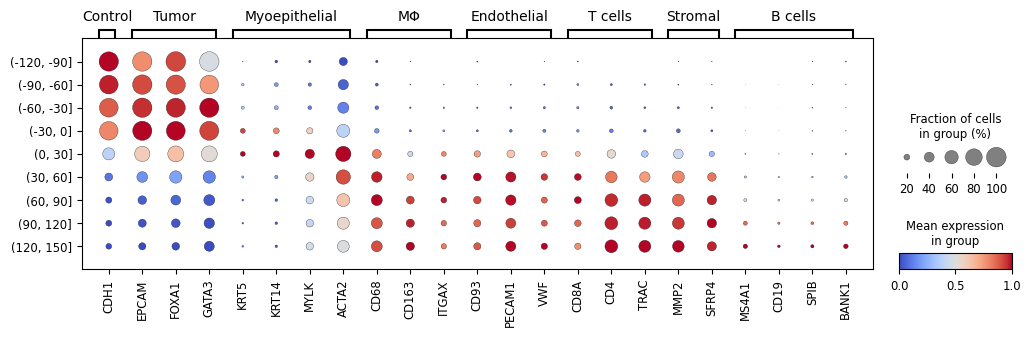

In [9]:
# Figure 2D
# gene marker dotplot
marker_genes_dict = {
    "Control": ["CDH1"],
    "Tumor": ["EPCAM", "FOXA1", "GATA3", ], 
    'Myoepithelial': ["KRT5", "KRT14", "MYLK", 'ACTA2',],
    "MΦ": ["CD68", "CD163", "ITGAX", ], 
    "Endothelial": ["CD93", "PECAM1", "VWF",],
    "T cells": ["CD8A", "CD4", "TRAC",], 
    "Stromal": ["MMP2", "SFRP4", ],
    "B cells": ["MS4A1", "CD19", "SPIB", "BANK1", 
               ], 
}

ax = sc.pl.dotplot(grid, marker_genes_dict, groupby='region_10', dendrogram=False, swap_axes=False, vmin=0.0, vcenter=0.5, color_map='coolwarm',
                   standard_scale='var', 
                   smallest_dot=0, 
                   figsize=(12,3), var_group_rotation=0, 
                   categories_order=['(-120, -90]', '(-90, -60]', '(-60, -30]', '(-30, 0]', '(0, 30]', '(30, 60]', '(60, 90]', '(90, 120]', '(120, 150]'], 
                  # save="Figure_2D.png"
                  )

### Figure 2E

In [10]:
# Filter genes and cells with at least 10 counts
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.filter_cells(adata,min_counts=10)

# Store the raw data for using PSTS
adata.raw = adata

# Normalization data
sc.pp.normalize_total(adata)
st.pp.log1p(adata)

Log transformation step is finished in adata.X


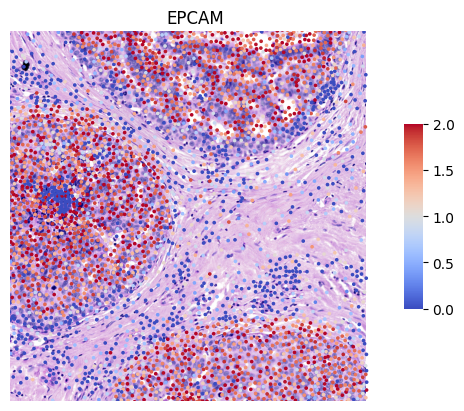

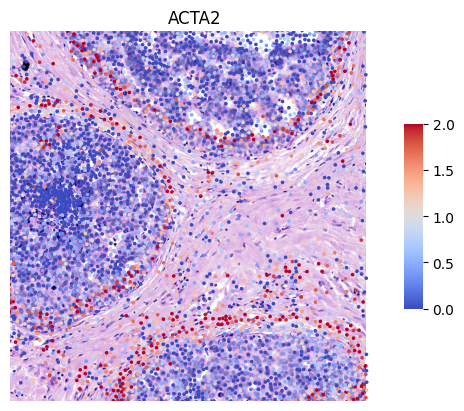

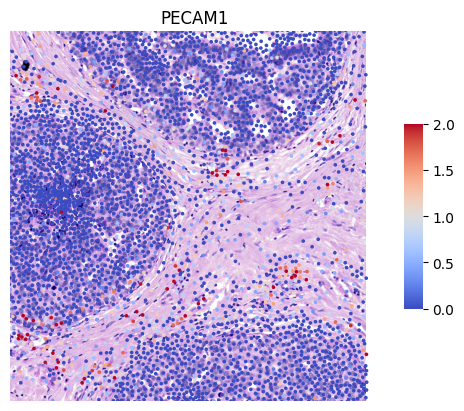

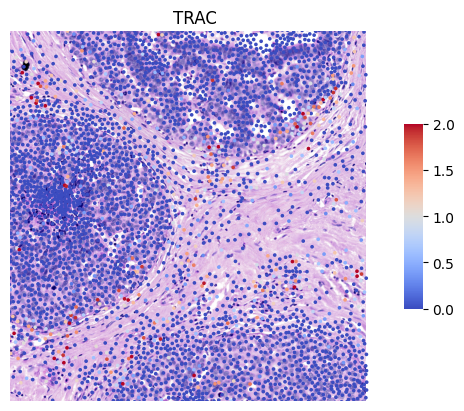

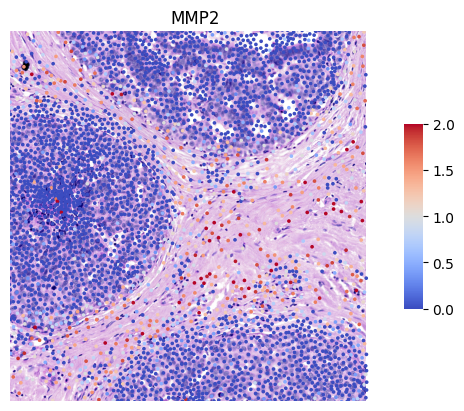

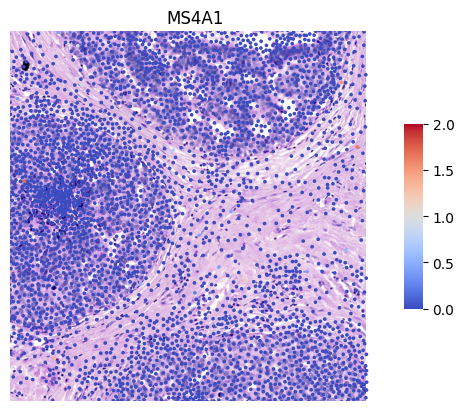

In [11]:
# Figure 2E
for gene in ["EPCAM", "ACTA2", "PECAM1", "TRAC", "MMP2", "MS4A1"]:
    st.pl.gene_plot(
        adata, gene_symbols=gene, show_color_bar=True, show_plot=True, 
        zoom_coord=[6750, 7550, 2180, 2980], cmap="coolwarm",vmax=2, cell_alpha=1, dpi=200
    )

## Figure 3.  Clustering and annotation of spatial domain based on gene expressions.

In [12]:
# Aggregate gene expression in the interval (-∞, 0] for each tumor solid
# Define new object "solid"
solid = sk.pp.convert_indivisual_solid(grid)

Calculatting gene expression of (-∞, 0]


### Figure 3A

In [13]:
# Filter genes and cells with at least 10 counts
solid.layers["counts"] = solid.X.copy()

# solid object has mean count of expression data of each tumor solid, we can consider it as density.
# The area of tumor solids are defferent each other, so normalize total underestimate gene expression of tumor solid which has large area.
# For the above policy, we recommend not to apply normalize total.
# sc.pp.normalize_total(solid)

# count data is exp distribution
sc.pp.log1p(solid)

# Keep raw data
solid.raw = solid

# reduction of dimension
sc.pp.pca(solid, n_comps=50)

# clustering
sc.pp.neighbors(solid, n_neighbors=20)
sc.tl.umap(solid)
sc.tl.leiden(solid)

/Users/sakai/miniconda3/envs/skny/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-05 20:58:38.775402: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


/Users/sakai/miniconda3/envs/skny/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


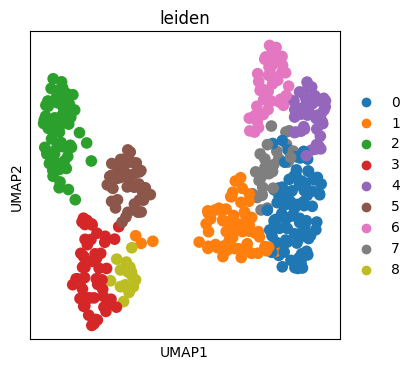

In [14]:
# Figure 3A
fig, ax = plt.subplots(figsize=(4, 4))

sc.pl.umap(
    solid,
    color=[
        "leiden",
    ],
    ax=ax,
    palette=sc.pl.palettes.vega_10, 
#    save="Figure_3A.png"
)


### Figure 3B

In [15]:
# convert leiden label to image data
df_shotest = solid.shortest.copy()
df_solid = solid.obs.copy()

# convert int data to apply imshow
df_solid["leiden"] = df_solid["leiden"].astype(int)
df_shotest = pd.merge(df_shotest, df_solid, on="solid", how="left")

(-0.5, 751.5, 546.5, -0.5)

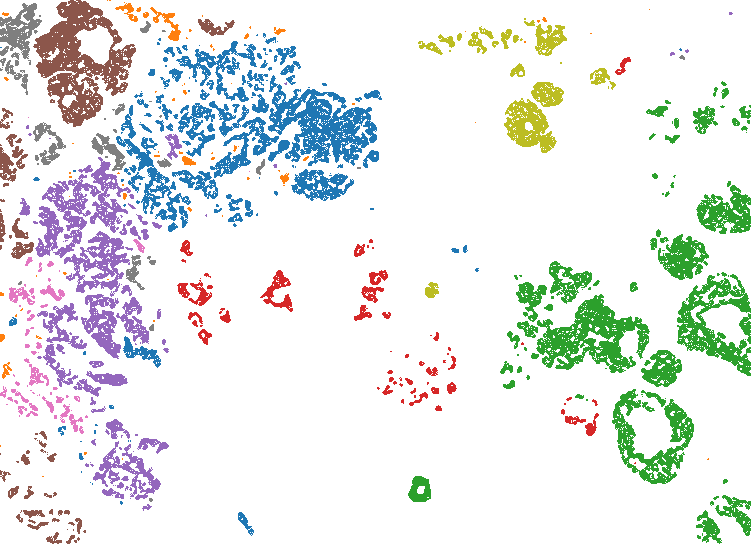

In [16]:
# Figure 3B
# match color to scanpy
gscmap=ListedColormap(
    sc.pl.palettes.vega_10[:len(solid.obs["leiden"].unique())]
)
gscmap.set_under(color='white') 
gscmap.set_bad(color='black') 

# save figure
fig, ax = plt.subplots(figsize=(N_COL, N_ROW), dpi=1, tight_layout=True)

image = np.array(df_shotest["leiden"].astype(float).fillna(-1)).reshape(N_ROW, N_COL)

ax.imshow(
    image, cmap=gscmap,
    vmin=0,
    vmax=len(solid.obs["leiden"].unique())-1,
)
ax.axis('off')

#plt.savefig("Figure_3B.png", dpi=1)

### Figure 3D

categories: 0, 1, 2, etc.
var_group_labels: Subtypes, Tumor, Myoepi, etc.


/Users/sakai/miniconda3/envs/skny/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


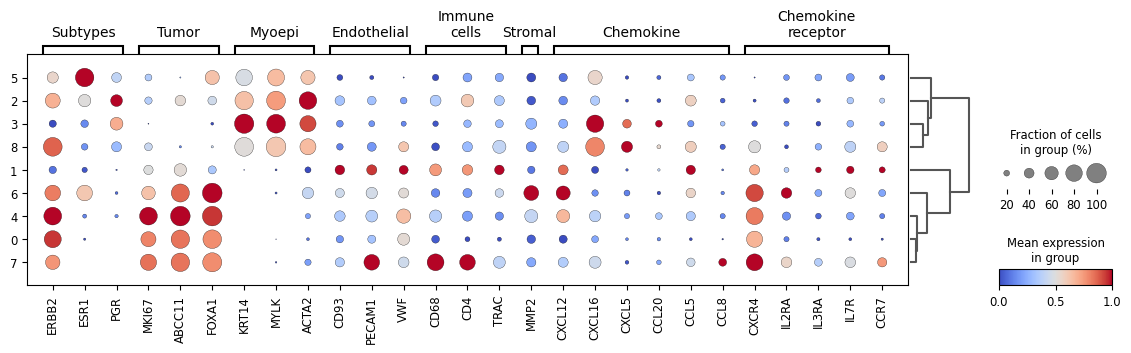

In [17]:
# Figure 3D
# scale the data
sc.pp.scale(solid, max_value=10)

marker_genes_dict = {
    'Subtypes': ['ERBB2', 'ESR1', 'PGR'],
    "Tumor": ["MKI67", "ABCC11", "FOXA1", ], 
    'Myoepi': ["KRT14", "MYLK", 'ACTA2',],
    "Endothelial": ["CD93", "PECAM1", "VWF",
                   ],
    "Immune\ncells": ["CD68", "CD4", "TRAC",], 
    "Stromal": ["MMP2"],
    "Chemokine": ["CXCL12", "CXCL16", "CXCL5", 'CCL20', 'CCL5', 'CCL8',], 
    "Chemokine\nreceptor": ["CXCR4",'IL2RA','IL3RA', 'IL7R', 'CCR7',], 
}

ax = sc.pl.dotplot(solid, marker_genes_dict, groupby='leiden', dendrogram=True, swap_axes=False, vmin=0.0, vcenter=0.5, color_map='coolwarm',
                   standard_scale='var', smallest_dot=0, figsize=(14, 3), var_group_rotation=0,
                  # save="Figure_3D.png"
                  )

## Figure 4. Estimating spatial domain trajectory reveals temporal gene expression gradient along with cancer progression.

### Figure 4A

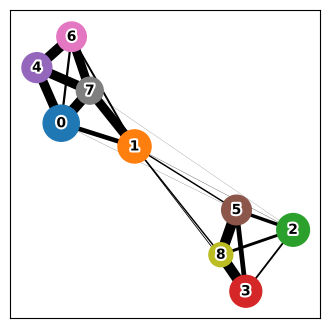

In [18]:
# Figure 4A
# generate graph structure based on simmilarity of gene expresssion of each cluster
# Uging PAGA algorithm
sc.tl.paga(solid, groups='leiden')

fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.paga(
    solid, color=['leiden', ], ax=ax, #legend_fontoutline=2,
#    save="Figure_4A.png", 
    node_size_scale=3, 
    fontoutline=3
)

### Figure 4B

In [19]:
# place tumor solids onto paga space
sc.tl.draw_graph(solid, init_pos='paga')

# calculate preudotime which root is 3
solid.uns['iroot'] = np.flatnonzero(solid.obs['leiden']  == '3')[0]
sc.tl.dpt(solid)

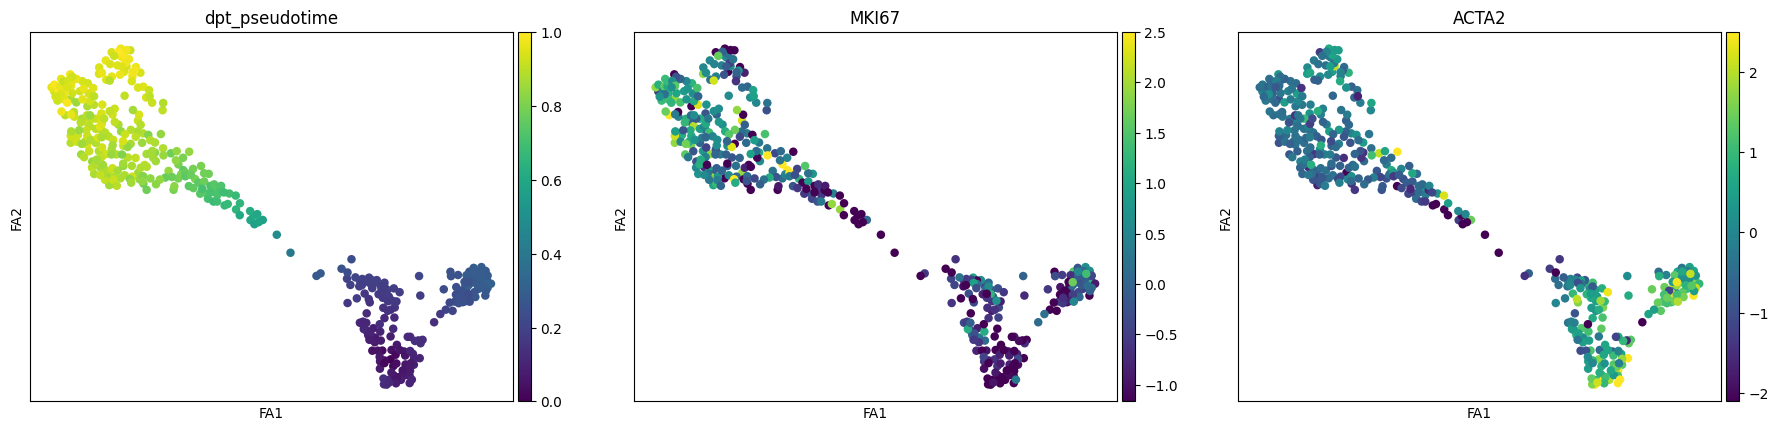

In [20]:
# Figure 4B
# each gene plot
sc.pl.draw_graph(
    solid, 
    color=['dpt_pseudotime', 
           "MKI67", "ACTA2", 
          ], 
    vmax=[1, 2.5, 2.5, 
         ],
    use_raw=True, sort_order=False, size=150, 
    save="Figure_4B.png", #cmap="coolwarm"
)

### Figure 4C

/Users/sakai/miniconda3/envs/skny/lib/python3.8/site-packages/scanpy/plotting/_tools/paga.py:1228: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/Users/sakai/miniconda3/envs/skny/lib/python3.8/site-packages/scanpy/plotting/_tools/paga.py:1277: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)
/var/folders/zs/fyyd4r8d2g91d_5cd08z3d3r0000h3/T/ipykernel_12667/1156251515.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


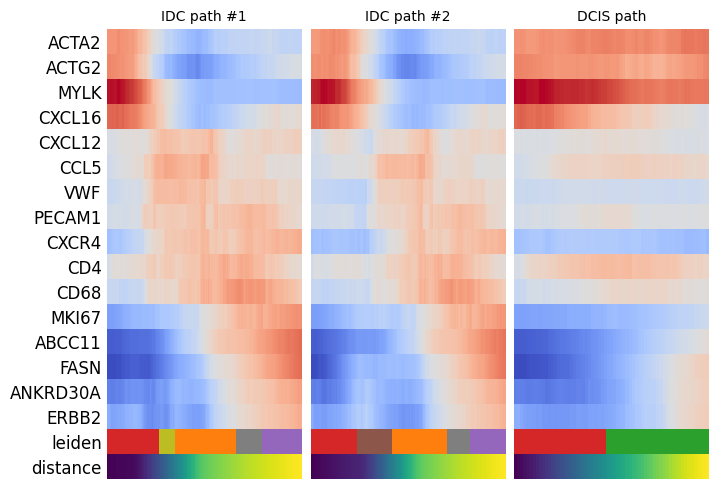

In [21]:
# gene list
gene_names = [
    "ACTA2", "ACTG2", "MYLK", 
    "CXCL16",
    "CXCL12", "CCL5",
    "VWF", "PECAM1", "CXCR4",
    "CD4", "CD68", 
    "MKI67", "ABCC11", "FASN", "ANKRD30A", "ERBB2",   # invasion marker 
]     


# define three pathway of tumor progression
paths = [
    ('IDC path #1', ["3", "8", "1", "7", "4"]),
    ('IDC path #2', ["3", "5", "1", "7", "4"]), 
    ('DCIS path', ["3", "2", ]), 
]

solid.obs['distance'] = solid.obs['dpt_pseudotime']
solid.obs['clusters'] = solid.obs['leiden']  # just a cosmetic change

# scale
sc.pp.scale(solid, max_value=10)

# plot heatmap
_, axs = plt.subplots(ncols=3, figsize=(7, 5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
plt.subplots_adjust(left=0.05, right=0.98, top=0.92, bottom=0.12)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        solid, path, gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='coolwarm',
        groups_key='leiden',
        color_maps_annotations={'distance': 'viridis'},
        title='{}'.format(descr),
        return_data=True,
        show=False)

plt.tight_layout()
#plt.savefig('Figure_4C.png', dpi=500)
plt.show()

### Figure 4D

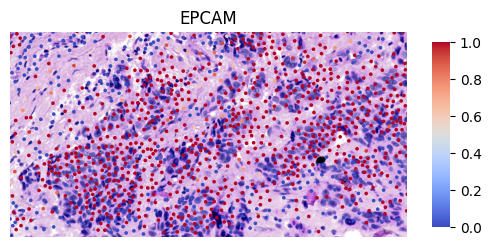

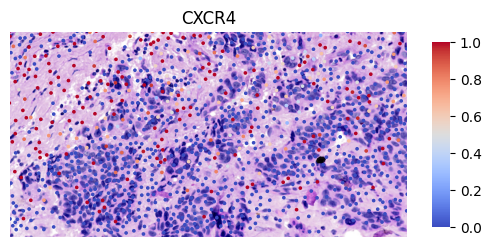

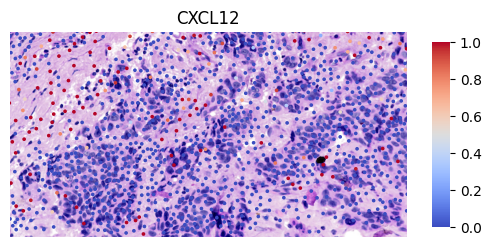

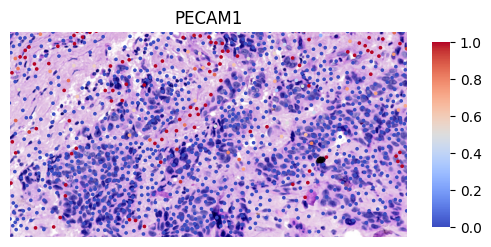

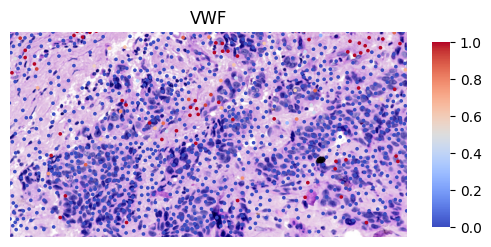

In [22]:
for gene in ["EPCAM", "CXCR4", "CXCL12", "PECAM1", "VWF"]:
    st.pl.gene_plot(
        adata, gene_symbols=gene, show_color_bar=True, show_plot=True, 
        zoom_coord=[1120, 1700, 0, 300], cmap="coolwarm", vmax=1, image_alpha=1, cell_alpha=1, #fname="ROI2_VWF",dpi=500
    )

## Figure 5. Spatial stratification of each spatial domain cluster elucidating endothelial cell invasion into the tumor.

In [23]:
# stratification
peri30 = sk.pp.convert_indivisual_peri(grid, section=30)
peri60 = sk.pp.convert_indivisual_peri(grid, section=60)
inside0 = sk.pp.convert_indivisual_solid(grid, section=0)

### Figure 5A

In [24]:
# convert leiden label to image data
df_shotest_peri30 = peri30.shortest.copy()
df_shotest_peri60 = peri60.shortest.copy()
df_shotest_inside0 = inside0.shortest.copy()

In [25]:
# add leiden clustering to distance data 
df_shotest_peri30 = pd.merge(
    df_shotest_peri30, df_solid, left_on="solid_peri", right_on="solid", how="left"
)
df_shotest_peri60 = pd.merge(
    df_shotest_peri60, df_solid, left_on="solid_peri", right_on="solid", how="left"
)
df_shotest_inside0 = pd.merge(
    df_shotest_inside0, df_solid, left_on="solid", right_on="solid", how="left"
)

(-0.5, 751.5, 546.5, -0.5)

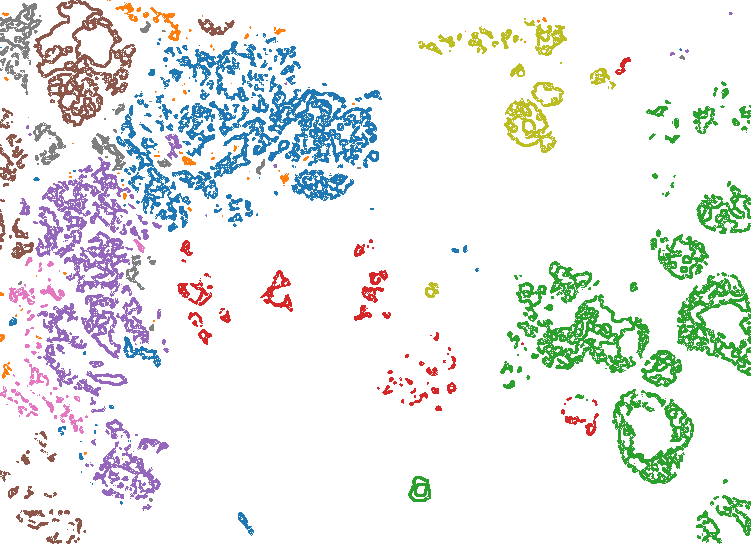

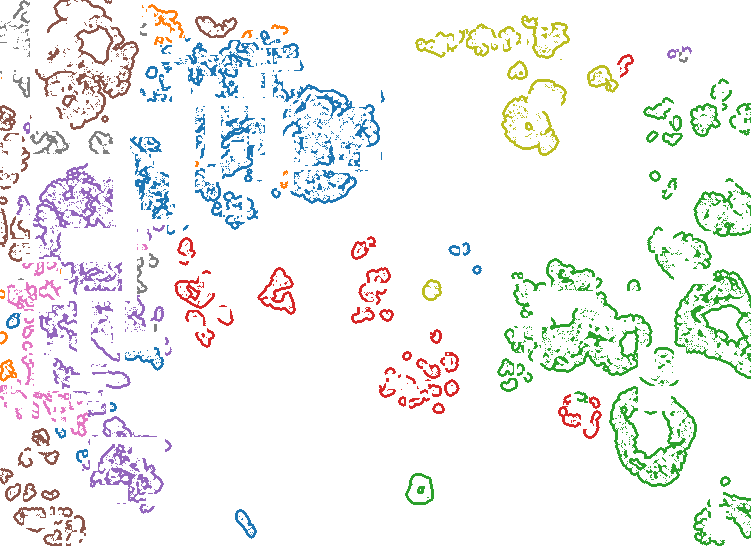

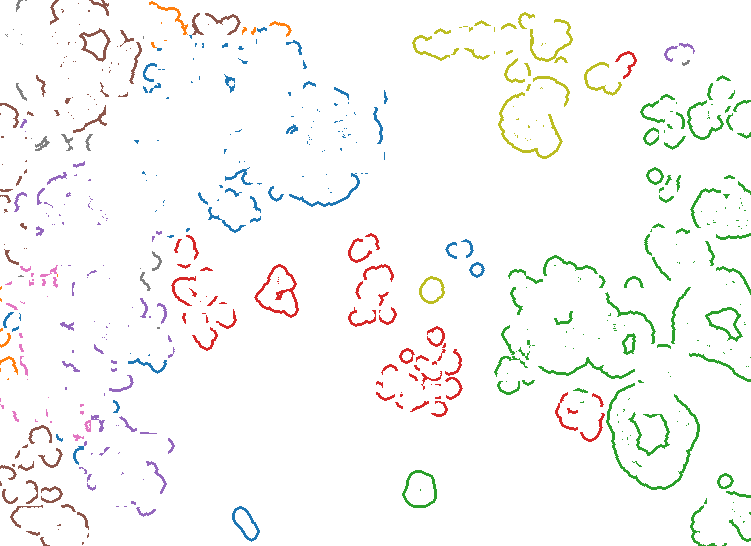

In [26]:
# Figure 5A
# match color to scanpy
gscmap=ListedColormap(
    sc.pl.palettes.vega_10[:len(solid.obs["leiden"].unique())]
)
gscmap.set_under(color='white') 
gscmap.set_bad(color='black') 

# save figure
fig, ax = plt.subplots(figsize=(N_COL, N_ROW), dpi=1, tight_layout=True)
image = np.array(df_shotest_inside0["leiden"].astype(float).fillna(-1)).reshape(N_ROW, N_COL)
ax.imshow(
    image, cmap=gscmap,
    vmin=0,
    vmax=len(solid.obs["leiden"].unique())-1,
)
ax.axis('off')
#plt.savefig("Figure_5A_1.png", dpi=1)


# save figure
fig, ax = plt.subplots(figsize=(N_COL, N_ROW), dpi=1, tight_layout=True)
image = np.array(df_shotest_peri30["leiden"].astype(float).fillna(-1)).reshape(N_ROW, N_COL)
ax.imshow(
    image, cmap=gscmap,
    vmin=0,
    vmax=len(solid.obs["leiden"].unique())-1,
)
ax.axis('off')
#plt.savefig("Figure_5A_2.png", dpi=1)

# save figure
fig, ax = plt.subplots(figsize=(N_COL, N_ROW), dpi=1, tight_layout=True)
image = np.array(df_shotest_peri60["leiden"].astype(float).fillna(-1)).reshape(N_ROW, N_COL)
ax.imshow(
    image, cmap=gscmap,
    vmin=0,
    vmax=len(solid.obs["leiden"].unique())-1,
)
ax.axis('off')
#plt.savefig("Figure_5A_3.png", dpi=1)

### Figure 5B

In [27]:
# annotation leiden to 
df_solid = solid.obs.copy()
peri30.obs = pd.merge(
    peri30.obs, df_solid[["solid", "leiden", "dpt_pseudotime"]], left_on="solid_peri", right_on="solid", how="left"
)
peri30.obs["leiden"] = peri30.obs["leiden"].astype(str)
peri30.obs["leiden"] = peri30.obs["leiden"].astype("category")
peri30.uns["leiden_colors"] = solid.uns["leiden_colors"]

peri60.obs = pd.merge(
    peri60.obs, df_solid[["solid", "leiden", "dpt_pseudotime"]], left_on="solid_peri", right_on="solid", how="left"
)
peri60.obs["leiden"] = peri60.obs["leiden"].astype(str)
peri60.obs["leiden"] = peri60.obs["leiden"].astype("category")
peri60.uns["leiden_colors"] = solid.uns["leiden_colors"]

inside0.obs = pd.merge(
    inside0.obs, df_solid[["solid", "leiden", "dpt_pseudotime"]], left_on="solid", right_on="solid", how="left"
)
inside0.obs["leiden"] = inside0.obs["leiden"].astype(str)
inside0.obs["leiden"] = inside0.obs["leiden"].astype("category")
inside0.uns["leiden_colors"] = solid.uns["leiden_colors"]

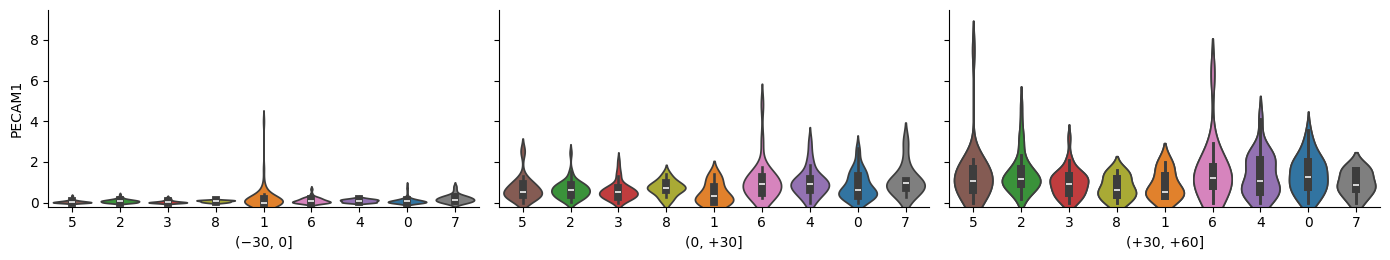

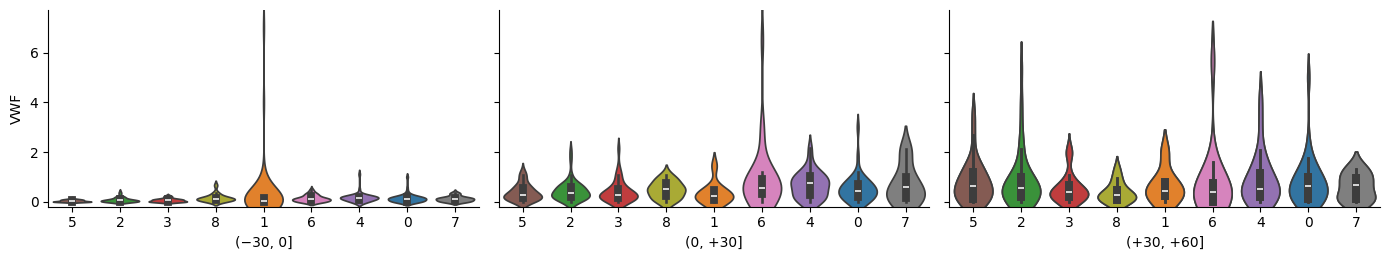

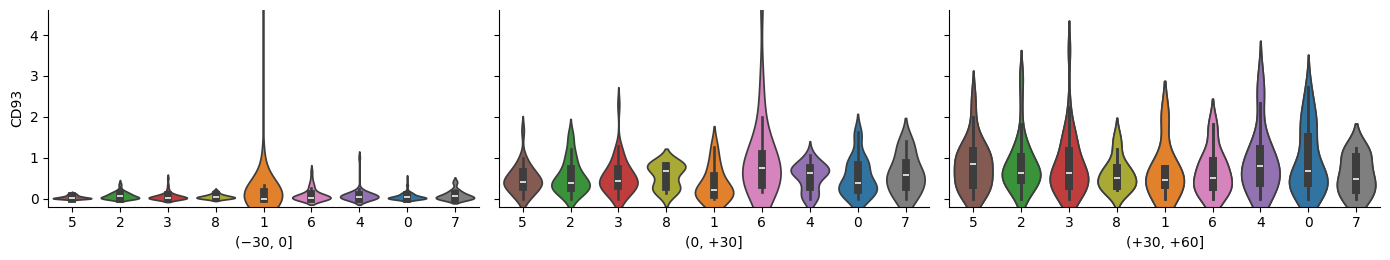

In [28]:
# Figure 5B
import warnings
warnings.filterwarnings("ignore")

gene_ls = [
    "PECAM1", "VWF", "CD93",
]

for gene in gene_ls:

    temp0 = pd.merge(
        inside0.to_df()[[gene]], inside0.obs[["leiden"]], 
        right_index=True, left_index=True, how="left"
    )
    
    temp30 = pd.merge(
        peri30.to_df()[[gene]], peri30.obs[["leiden"]], 
        right_index=True, left_index=True, how="left"
    )
    
    temp60 = pd.merge(
        peri60.to_df()[[gene]], peri60.obs[["leiden"]], 
        right_index=True, left_index=True, how="left"
    )

    fig, ax = plt.subplots(ncols=3, figsize=(14, 2.7), sharey="all")

    
    # (+30, +60] ------------------------
    sns.violinplot(
        data=temp60, x="leiden", y=gene, scale="width", orient="vertical", ax=ax[2], 
        palette=[inside0.uns["leiden_colors"][int(i)] for i in ["5", "2", "3", "8", "1", "6", "4", "0", "7"]], 
        order=["5", "2", "3", "8", "1", "6", "4", "0", "7"]
    )
    # setting
    #plt.ylim(-.5, )
    ax[2].axes.set_xlabel("(+30, +60]")
    ax[2].axes.set_ylabel(None)
    ax[2].set_ylim(-.2)
    ax[2].spines[['right', 'top']].set_visible(False)

    
    # (−30, 0] ------------------------
    sns.violinplot(
        data=temp0, x="leiden", y=gene, scale="width", orient="vertical", ax=ax[0], 
        palette=[inside0.uns["leiden_colors"][int(i)] for i in ["5", "2", "3", "8", "1", "6", "4", "0", "7"]], 
        order=["5", "2", "3", "8", "1", "6", "4", "0", "7"]
    )
    # setting
    ax[0].axes.set_xlabel("(−30, 0]")
    ax[0].set_ylim(-.2)
    ax[0].spines[['right', 'top']].set_visible(False)
    
    
    # (0, +30] ------------------------
    sns.violinplot(
        data=temp30, x="leiden", y=gene, scale="width", orient="vertical", ax=ax[1], 
        palette=[inside0.uns["leiden_colors"][int(i)] for i in ["5", "2", "3", "8", "1", "6", "4", "0", "7"]], 
        order=["5", "2", "3", "8", "1", "6", "4", "0", "7"]
    )
    # setting
    #plt.ylim(-.5, )
    ax[1].axes.set_xlabel("(0, +30]")
    ax[1].axes.set_ylabel(None)
    ax[1].set_ylim(-.2)
    ax[1].spines[['right', 'top']].set_visible(False)
    
    
    # (+30, +60] ------------------------
    sns.violinplot(
        data=temp60, x="leiden", y=gene, scale="width", orient="vertical", ax=ax[2], 
        palette=[inside0.uns["leiden_colors"][int(i)] for i in ["5", "2", "3", "8", "1", "6", "4", "0", "7"]], 
        order=["5", "2", "3", "8", "1", "6", "4", "0", "7"]
    )
    # setting
    #plt.ylim(-.5, )
    ax[2].axes.set_xlabel("(+30, +60]")
    ax[2].axes.set_ylabel(None)
    ax[2].set_ylim(-.2)
    ax[2].spines[['right', 'top']].set_visible(False)

    plt.tight_layout()
    #plt.savefig(f"Figure_5B.png", dpi=500)

## Figure 6. Comparison of immune cells distribution in microenvironments between DCIS and IDC regions.

In [29]:
# calculate gene expression in each section
#gene = "CD8A"
sk.pl.distance_gene_plot(grid, gene, x_range=[380, 460], y_range=[25, 105], show=False)  # ROI 1
sk.pl.distance_gene_plot(grid, gene, x_range=[335, 415], y_range=[225, 305], show=False)  # ROI 2
sk.pl.distance_gene_plot(grid, gene, x_range=[240, 320], y_range=[250, 330], show=False)  # ROI 3
sk.pl.distance_gene_plot(grid, gene, x_range=[170, 250], y_range=[300, 380], show=False) # ROI 4

sk.pl.distance_gene_plot(grid, gene, x_range=[335, 415], y_range=[120, 200], show=False)  # ROI 5
sk.pl.distance_gene_plot(grid, gene, x_range=[270, 350], y_range=[150, 230], show=False)  # ROI 6
sk.pl.distance_gene_plot(grid, gene, x_range=[90, 170], y_range=[340, 420], show=False)  # ROI 7
sk.pl.distance_gene_plot(grid, gene, x_range=[125, 205], y_range=[435, 515], show=False)  # ROI 8

In [30]:
# extract gene expression data of each section
df_grid_roi1 = getattr(grid, "gene_expresion_by_region_x_[380, 460]_y_[25, 105]")
df_grid_roi2 = getattr(grid, "gene_expresion_by_region_x_[335, 415]_y_[225, 305]")
df_grid_roi3 = getattr(grid, "gene_expresion_by_region_x_[240, 320]_y_[250, 330]")
df_grid_roi4 = getattr(grid, "gene_expresion_by_region_x_[170, 250]_y_[300, 380]")

df_grid_roi5 = getattr(grid, "gene_expresion_by_region_x_[335, 415]_y_[120, 200]")
df_grid_roi6 = getattr(grid, "gene_expresion_by_region_x_[270, 350]_y_[150, 230]")
df_grid_roi7 = getattr(grid, "gene_expresion_by_region_x_[90, 170]_y_[340, 420]")
df_grid_roi8 = getattr(grid, "gene_expresion_by_region_x_[125, 205]_y_[435, 515]")

In [31]:
# setting marker gene 
b_cell_gene = ["CD19"]
cd4_cell_gene = ["CD4"]
cd8_cell_gene = ["CD8A"]
treg_cell_gene = ["CTLA4"]
dc_cell_gene = ["ITGAX"]
M2macro_cell_gene = ["CD163"]
M1macro_cell_gene = ["CD68"]

cell_marker_ls = [
    b_cell_gene, cd4_cell_gene, cd8_cell_gene, treg_cell_gene, dc_cell_gene, M1macro_cell_gene, M2macro_cell_gene, 
]

cell_ls = [
    "CD19", "CD4", "CD8A", "FOXP3", "ITGAX", "CD68", "CD163",
]

In [32]:
df_res = pd.DataFrame()
for i, s in zip(cell_marker_ls, cell_ls):
    df_strat_cell = pd.concat(
        [df_grid_roi1.loc[i, :].mean(), 
         df_grid_roi2.loc[i, :].mean(), 
         df_grid_roi3.loc[i, :].mean(), 
         df_grid_roi4.loc[i, :].mean(), 
         df_grid_roi5.loc[i, :].mean(), 
         df_grid_roi6.loc[i, :].mean(),
         df_grid_roi7.loc[i, :].mean(),
         df_grid_roi8.loc[i, :].mean(),], axis=1
    ).dropna()
    df_strat_cell.columns = [f"ROI {str(i+1)}" for i in range(8)]
    df_strat_cell = df_strat_cell.stack().reset_index()
    df_strat_cell = df_strat_cell.rename(
        columns={"level_0": "Interval", "level_1": "ROI", 0: "value"}
    )
    df_strat_cell["Cell"] = s
    df_res = pd.concat([df_res, df_strat_cell])
df_res = df_res.reset_index(drop=True)
    
    

### Figure 6B

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


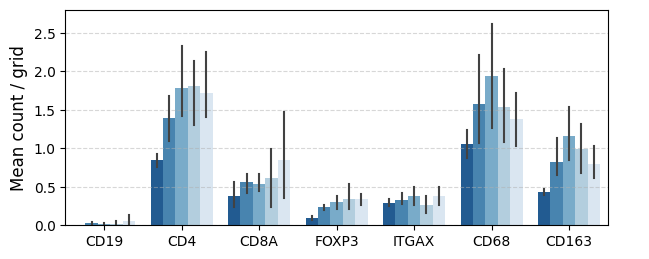

In [33]:
df_res["Interval"] = df_res["Interval"].astype(str)
# extract outside of spatial domain
df_res = df_res[df_res["Interval"] != "(-30.0, 0.0]"]

fig, axes = plt.subplots(
    ncols=1, figsize=(7, 2.8)
)
barplot = sns.barplot(
    df_res[df_res["ROI"].isin(["ROI 5", "ROI 6", "ROI 7", "ROI 8"])], x="Cell", y="value", hue="Interval", palette="Blues_r", legend=False, errwidth=1.5, 
)
plt.ylim(0, 2.8)
plt.xlabel("Marker gene", fontsize=12)
plt.xlabel("", fontsize=12)
plt.ylabel("Mean count / grid", fontsize=12)
plt.grid(linestyle="--",alpha=0.5,zorder=1, axis="y")

#plt.savefig("Figure_6B_1.png", dpi=300)
fig.legend(loc='center left', bbox_to_anchor=(0.92, .5), frameon=False)
fig.show()

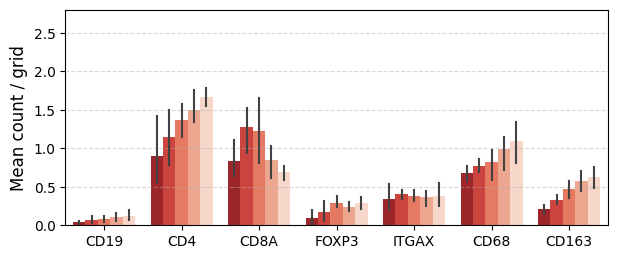

In [34]:
plt.subplots(figsize=(7, 2.8))
sns.barplot(
    df_res[df_res["ROI"].isin(["ROI 1", "ROI 2", "ROI 3", "ROI 4"])], x="Cell", y="value", hue="Interval", palette="Reds_r", legend=False, errwidth=1.5, #edgecolor="yellow"
)
plt.ylim(0, 2.8)
plt.xlabel("Marker gene", fontsize=12)
plt.xlabel("", fontsize=12)
plt.ylabel("Mean count / grid", fontsize=12)
plt.grid(linestyle="--",alpha=0.5,zorder=1, axis="y")
# plt.savefig("Figure_6B_2.png", dpi=300)

In [36]:
# for GLM model
df_res_DCIS = df_res[df_res["ROI"].isin(["ROI 1", "ROI 2", "ROI 3", "ROI 4"])]
df_res_IDC = df_res[df_res["ROI"].isin(["ROI 5", "ROI 6", "ROI 7", "ROI 8"])]

# annotation group
df_res_IDC["group"] = "IDC"
df_res_DCIS["group"] = "DCIS"

# concat
df_res_concat = pd.concat([df_res_IDC, df_res_DCIS])
df_res_concat = df_res_concat[df_res_concat["Interval"] != "(-30.0, 0.0]"]

# dummy variable
df_res_concat['group'] = pd.Categorical(df_res_concat['group'])
#df_res_concat['group_code'] = df_res_concat['group'].cat.codes
df_res_concat['group_code'] = df_res_concat.group.replace(
    {'IDC': 1, 'DCIS': 0}
)

df_res_concat['Interval'] = pd.Categorical(df_res_concat['Interval'])
#df_res_concat['Interval_code'] = df_res_concat['Interval'].cat.codes

df_res_concat['Interval_code'] = df_res_concat.Interval.replace(
    {'(-30.0, 0.0]': 0, '(0.0, 30.0]': 0, 
     '(30.0, 60.0]': 1, '(60.0, 90.0]': 2, '(90.0, 120.0]': 3, '(120.0, 150.0]': 4}
)

In [37]:
# dammy variables
df_res_concat["group_code"] = df_res_concat["group_code"].astype(int)
df_res_concat["Interval_code"] = df_res_concat["Interval_code"].astype(int)
df_res_concat["group_interval"] = df_res_concat["group_code"] * df_res_concat["Interval_code"]

In [38]:
# construct GLM model for each gene
df_lin_res = pd.DataFrame()

for i in df_res_concat["Cell"].unique():
    model = sm.GLM(df_res_concat.groupby("Cell").get_group(i)['value'], 
               sm.add_constant(df_res_concat.groupby("Cell").get_group(i)[['Interval_code', 'group_code', "group_interval"]]), family=sm.families.Gaussian()).fit()
    df_temp = model.summary2().tables[1]
    df_temp["Cell"] = i
    df_lin_res = pd.concat([df_lin_res, df_temp])

df_lin_res = df_lin_res.reset_index()
df_lin_res = df_lin_res[df_lin_res["index"] != "const"]

In [39]:
# shaping
df_lin_res['P>|z|'] = df_lin_res['P>|z|'].apply(lambda x: '<0.001' if x < 0.001 else format(x, '.4f'))
df_lin_res['Coef'] = df_lin_res.apply(lambda row: f"{format(row['Coef.'], '.2f')} [{format(row['[0.025'], '.2f')}, {format(row['0.975]'], '.2f')}]", axis=1)

In [40]:
# Figure 6B
df_lin_res[["Cell", "P>|z|", "Coef"]]

Cell   P>|z|                  Coef
1    CD19  0.0047     0.02 [0.01, 0.03]
2    CD19  0.1270   -0.04 [-0.09, 0.01]
3    CD19  0.3027   -0.01 [-0.03, 0.01]
5     CD4  0.0024     0.19 [0.07, 0.31]
6     CD4  0.5125    0.14 [-0.28, 0.57]
7     CD4  0.7654    0.03 [-0.15, 0.20]
9    CD8A  0.2246   -0.07 [-0.18, 0.04]
10   CD8A  <0.001  -0.73 [-1.13, -0.34]
11   CD8A  0.0367     0.17 [0.01, 0.33]
13  FOXP3  0.0074     0.05 [0.01, 0.08]
14  FOXP3  0.8139    0.01 [-0.10, 0.13]
15  FOXP3  0.5454    0.01 [-0.03, 0.06]
17  ITGAX  0.7707    0.01 [-0.03, 0.04]
18  ITGAX  0.4022   -0.06 [-0.19, 0.07]
19  ITGAX  0.8517    0.01 [-0.05, 0.06]
21   CD68  0.1382    0.11 [-0.03, 0.25]
22   CD68  0.0039     0.71 [0.23, 1.20]
23   CD68  0.6489   -0.05 [-0.24, 0.15]
25  CD163  0.0110     0.11 [0.02, 0.19]
26  CD163  0.0029     0.44 [0.15, 0.72]
27  CD163  0.7695   -0.02 [-0.13, 0.10]

### Figure 6C

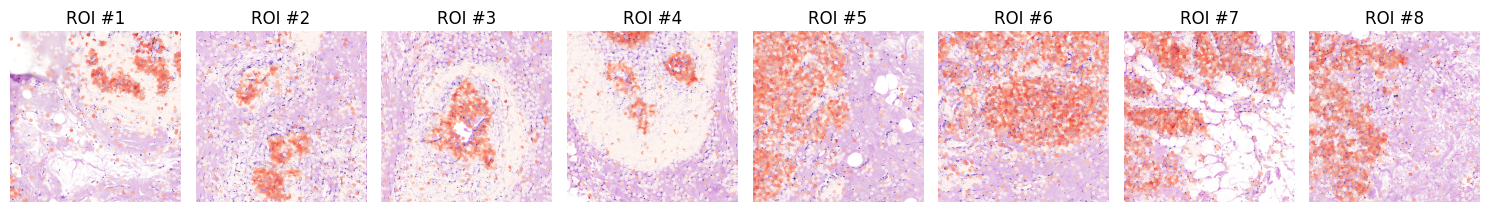

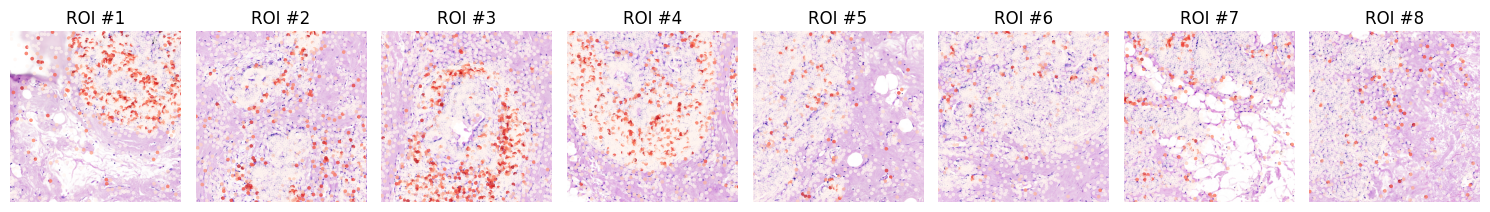

In [41]:
# Validation of CDH1 expression on space using stlearn
gene = ["CDH1"]

fig, axes = plt.subplots(ncols=8, figsize=(15, 2.5))

st.pl.gene_plot(adata, gene_symbols=gene, ax=axes[0], zoom_coord=[3800, 4600, 250, 1050], show_color_bar=False, cmap="Reds") # ROI #1
st.pl.gene_plot(adata, gene_symbols=gene, ax=axes[1], zoom_coord=[3350, 4150, 2250, 3050], show_color_bar=False, cmap="Reds") # ROI #2
st.pl.gene_plot(adata, gene_symbols=gene, ax=axes[2], zoom_coord=[2400, 3200, 2500, 3300], show_color_bar=False, cmap="Reds") # ROI #3
st.pl.gene_plot(adata, gene_symbols=gene, ax=axes[3], zoom_coord=[1700, 2500, 3000, 3800], show_color_bar=False, cmap="Reds") # ROI #4

st.pl.gene_plot(adata, gene_symbols=gene, ax=axes[4], zoom_coord=[3350, 4150, 1200, 2000], show_color_bar=False, cmap="Reds") # ROI #5
st.pl.gene_plot(adata, gene_symbols=gene, ax=axes[5], zoom_coord=[2700, 3500, 1500, 2300], show_color_bar=False, cmap="Reds") # ROI #6
st.pl.gene_plot(adata, gene_symbols=gene, ax=axes[6], zoom_coord=[900, 1700, 3400, 4200], show_color_bar=False, cmap="Reds") # ROI #7
st.pl.gene_plot(adata, gene_symbols=gene, ax=axes[7], zoom_coord=[1250, 2050, 4350, 5150], show_color_bar=False, cmap="Reds") # ROI #8

# Invert y-axis for all plots
for ax in axes:
    ax.invert_yaxis()

axes[0].set_title(f'ROI #1')
axes[1].set_title(f'ROI #2')
axes[2].set_title(f'ROI #3')
axes[3].set_title(f'ROI #4')
axes[4].set_title(f'ROI #5')
axes[5].set_title(f'ROI #6')
axes[6].set_title(f'ROI #7')
axes[7].set_title(f'ROI #8')

plt.tight_layout()
#plt.savefig("Figure_6C_1.png", dpi=300)
plt.show()

# Validation of CD8A expression on space using stlearn
gene = ["CD8A"]

fig, axes = plt.subplots(ncols=8, figsize=(15, 2.5))
st.pl.gene_plot(adata, gene_symbols=gene, ax=axes[0], zoom_coord=[3800, 4600, 250, 1050], show_color_bar=False, cmap="Reds") # ROI #1
st.pl.gene_plot(adata, gene_symbols=gene, ax=axes[1], zoom_coord=[3350, 4150, 2250, 3050], show_color_bar=False, cmap="Reds") # ROI #2
st.pl.gene_plot(adata, gene_symbols=gene, ax=axes[2], zoom_coord=[2400, 3200, 2500, 3300], show_color_bar=False, cmap="Reds") # ROI #3
st.pl.gene_plot(adata, gene_symbols=gene, ax=axes[3], zoom_coord=[1700, 2500, 3000, 3800], show_color_bar=False, cmap="Reds") # ROI #4

st.pl.gene_plot(adata, gene_symbols=gene, ax=axes[4], zoom_coord=[3350, 4150, 1200, 2000], show_color_bar=False, cmap="Reds") # ROI #5
st.pl.gene_plot(adata, gene_symbols=gene, ax=axes[5], zoom_coord=[2700, 3500, 1500, 2300], show_color_bar=False, cmap="Reds") # ROI #6
st.pl.gene_plot(adata, gene_symbols=gene, ax=axes[6], zoom_coord=[900, 1700, 3400, 4200], show_color_bar=False, cmap="Reds") # ROI #7
st.pl.gene_plot(adata, gene_symbols=gene, ax=axes[7], zoom_coord=[1250, 2050, 4350, 5150], show_color_bar=False, cmap="Reds") # ROI #8

# Invert y-axis for all plots
for ax in axes:
    ax.invert_yaxis()

axes[0].set_title(f'ROI #1')
axes[1].set_title(f'ROI #2')
axes[2].set_title(f'ROI #3')
axes[3].set_title(f'ROI #4')
axes[4].set_title(f'ROI #5')
axes[5].set_title(f'ROI #6')
axes[6].set_title(f'ROI #7')
axes[7].set_title(f'ROI #8')

plt.tight_layout()
#plt.savefig("Figure_6C_2.png", dpi=300)
plt.show()

## Figure 7. Cataloguing spatial domains using Xenium data of hepatic metastasis from colorectal cancer in TRIUMPH trial.

In [ ]:
# We will provide data after paper is accepted.